# Setup

In [39]:
import pandas as pd
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

# Loading the data

In [2]:
# Loading the data
def load_data(filepath):
    data,meta = arff.loadarff(filepath)
    my_df = pd.DataFrame(data)
    my_df = my_df.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x) #Encoding from byte to string
    return my_df

def explore_data(my_df):
    print(my_df.head().T)
    print(my_df.describe())
    print(my_df.info())

# Data Cleaning

In [3]:
def cleaning(my_df):
    cleaned_df= my_df.drop_duplicates()
    return cleaned_df

# Visualizing the data

In [4]:
def plot_bar_chart(my_df):
    var_cat = my_df.select_dtypes(include=['object'])
    
    for column in var_cat.columns:
        plt.figure(figsize=(12, 6))
        ax = sns.countplot(data=df, x=column)
        
        plt.title(f'Distribution of {column}', fontsize=16)
        plt.xlabel(column, fontsize=14)
        plt.ylabel('Count', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                    textcoords='offset points')

        warnings.filterwarnings('ignore', category=FutureWarning)
        ax.grid(True, linestyle='--', axis='y')

        plt.tight_layout()  
        plt.show()
        
def plot_heat_map(my_df):
    cat_encoder= LabelEncoder()
    lista_colmuns= [col for col in my_df.columns]
    
    for col in lista_colmuns:
        my_df[col]=cat_encoder.fit_transform(my_df[col])

    corr_matrix=my_df.corr()
    plt.figure(figsize=(10,10))
    plt.title(f'Relationship between Performance')
    sns.heatmap(corr_matrix,annot=True)

# Preprocessing and feature engineering

In [21]:
def OneHot_coding(my_df):
    df_high_corr_col = my_df.copy()
    df_high_corr_col=df_high_corr_col[['Performance','Class_ X_Percentage', 'Class_XII_Percentage', 'medium', 'Caste']]
    
    #One OneHot Encoding 
    df_OneHot_coded = pd.get_dummies(df_high_corr_col, columns=['Class_ X_Percentage', 'Class_XII_Percentage', 'medium', 'Caste'], drop_first=True)
    
    #Label enconder only in Target
    label_encoder = LabelEncoder()
    df_OneHot_coded['Performance'] = label_encoder.fit_transform(df_OneHot['Performance'])
    
    return df_OneHot_coded
    

# Splitting the dataset

In [18]:
def split_data(df_OneHot, target):
    y = df_OneHot[target]
    X=df_OneHot.drop('Performance',axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Training the model

In [19]:
def train_model(X_train, y_train):
    random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    random_forest_classifier.fit(X_train, y_train)
    return random_forest_classifier
    

# Evaluating the model

In [42]:
def evaluate_model(model, X_test, y_test):
    y_pred = random_forest_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f'Model accuracy: {accuracy * 100:.2f}%')
    
    
    y_pred = random_forest_classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    report = classification_report(y_test, y_pred)
    print("Classification Report before Grid Search:")
    print(report)
    

# Improving the model
## Random Forest + Grid Search

In [41]:
def improve_RF(X_train, y_train, X_test, y_test):
    
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }


    random_forest_classifier = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=random_forest_classifier, param_grid=param_grid, 
                               cv=5, n_jobs=-1, verbose=2, scoring='accuracy')


    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print(f"Best Parameters: {grid_search.best_params_}")


    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return best_model, accuracy

In [47]:
def run_pipeline(filepath):
    df=load_data(filepath)
    #EDA
    explore_data(df)
    #Cleaning
    clean_df=cleaning(df)
    clean_df.info()
    #Visualizing the data
    plot_bar_chart(clean_df)
    view_heat_map=clean_df.copy()
    plot_heat_map(view_heat_map)
    #Preprocessing and feature engineering
    target= "Performance"
    df_OneHot= OneHot_coding(df)
    #Splitting the dataset
    X_train, X_test, y_train, y_test = split_data(df_OneHot,target)
    #Training the model
    RF_classifier= train_model(X_train,y_train)
    #Evaluating the model
    evaluate_model(RF_classifier,X_test,y_test)
    #Improve the model
    best_model, improved_acc = improve_RF(X_train, y_train, X_test, y_test)

                              0               1           2               3  \
Performance           Excellent       Excellent   Excellent       Excellent   
Gender                     male            male        male            male   
Caste                   General             OBC         OBC         General   
coaching                     NO              WA          OA              WA   
time                        ONE             TWO         TWO             ONE   
Class_ten_education        SEBA            SEBA      OTHERS            SEBA   
twelve_education          AHSEC           AHSEC        CBSE           AHSEC   
medium                  ENGLISH          OTHERS     ENGLISH          OTHERS   
Class_ X_Percentage   Excellent       Excellent   Excellent       Excellent   
Class_XII_Percentage  Excellent       Excellent   Excellent       Excellent   
Father_occupation        DOCTOR  SCHOOL_TEACHER    BUSINESS  SCHOOL_TEACHER   
Mother_occupation        OTHERS      HOUSE_WIFE  HOU

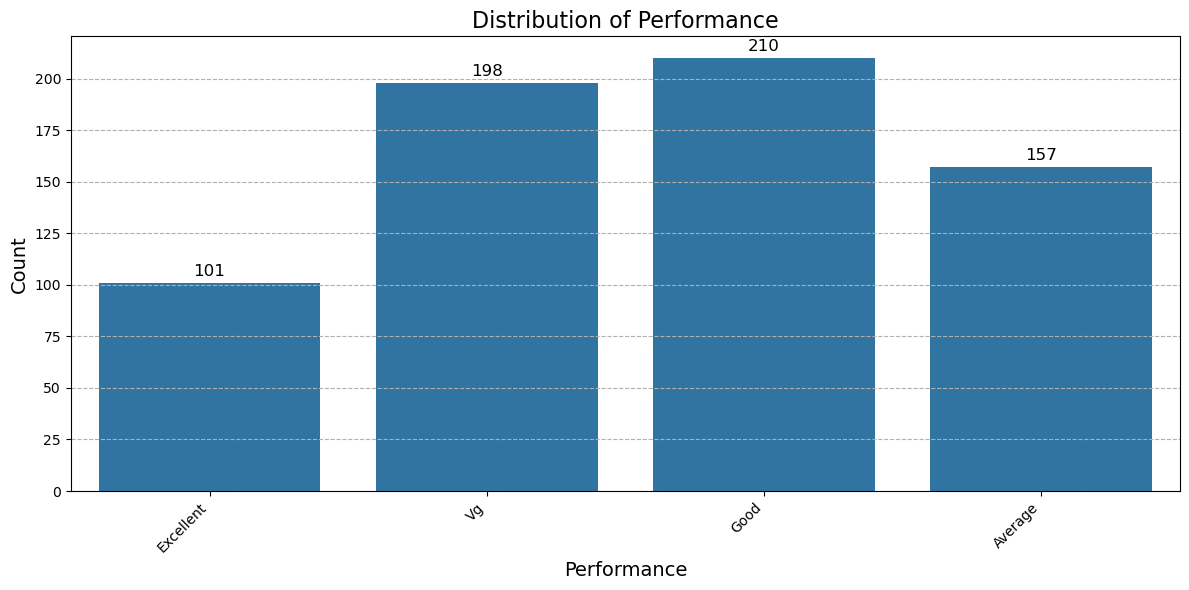

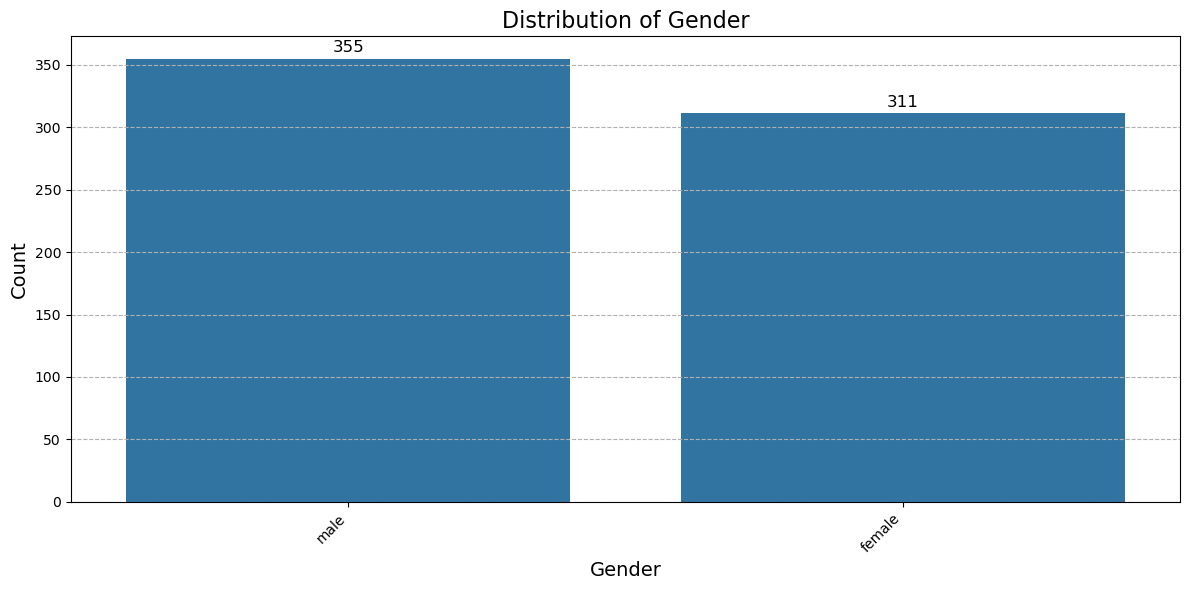

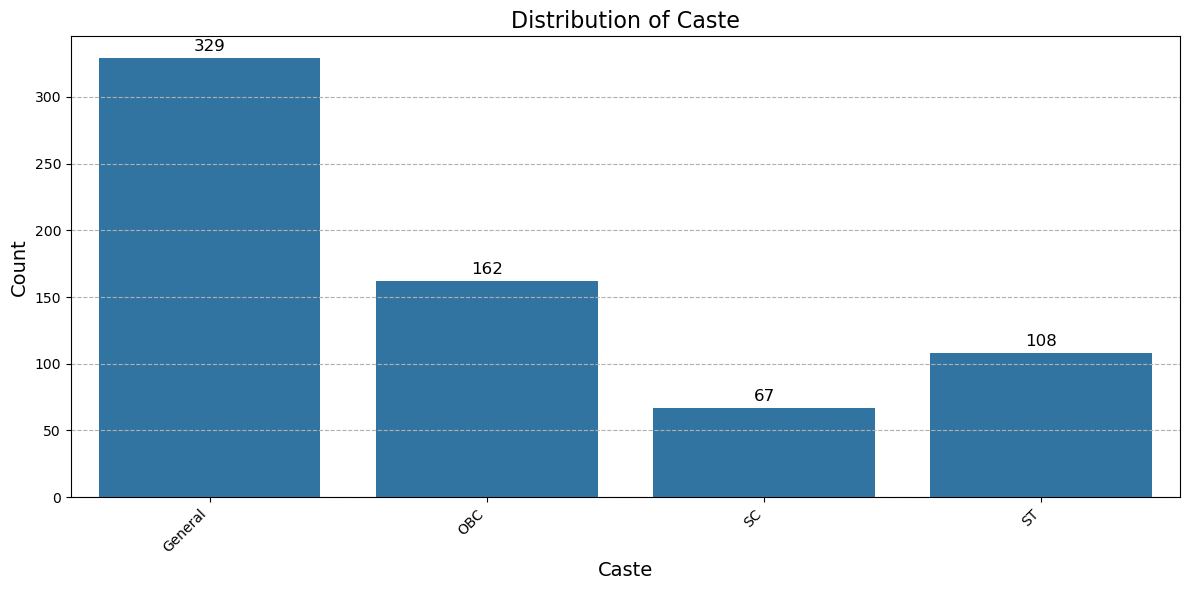

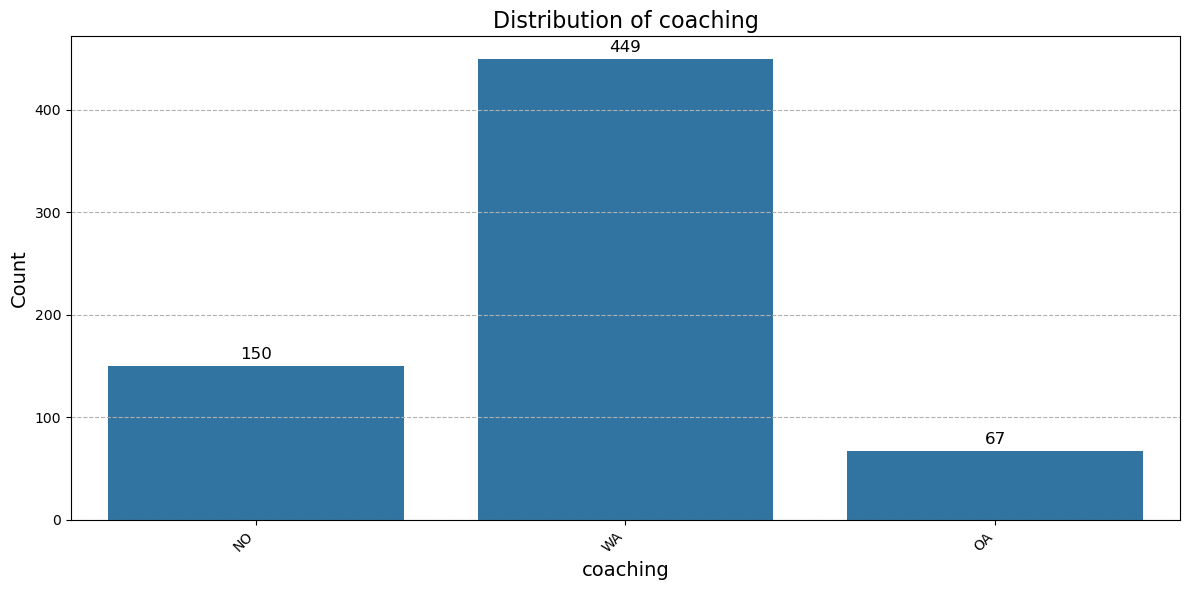

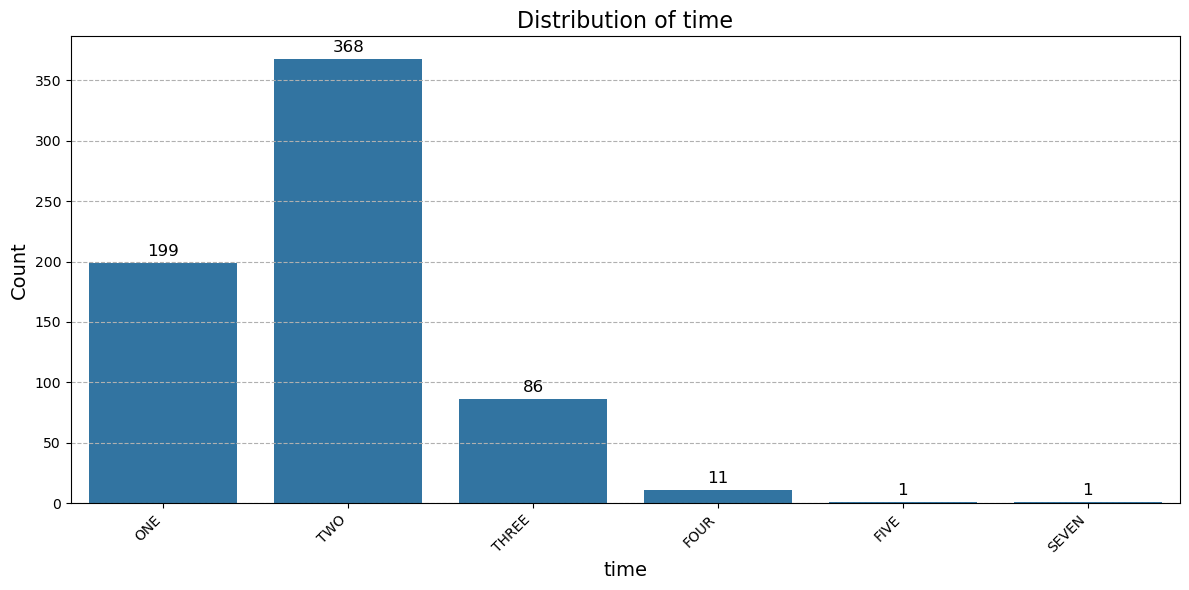

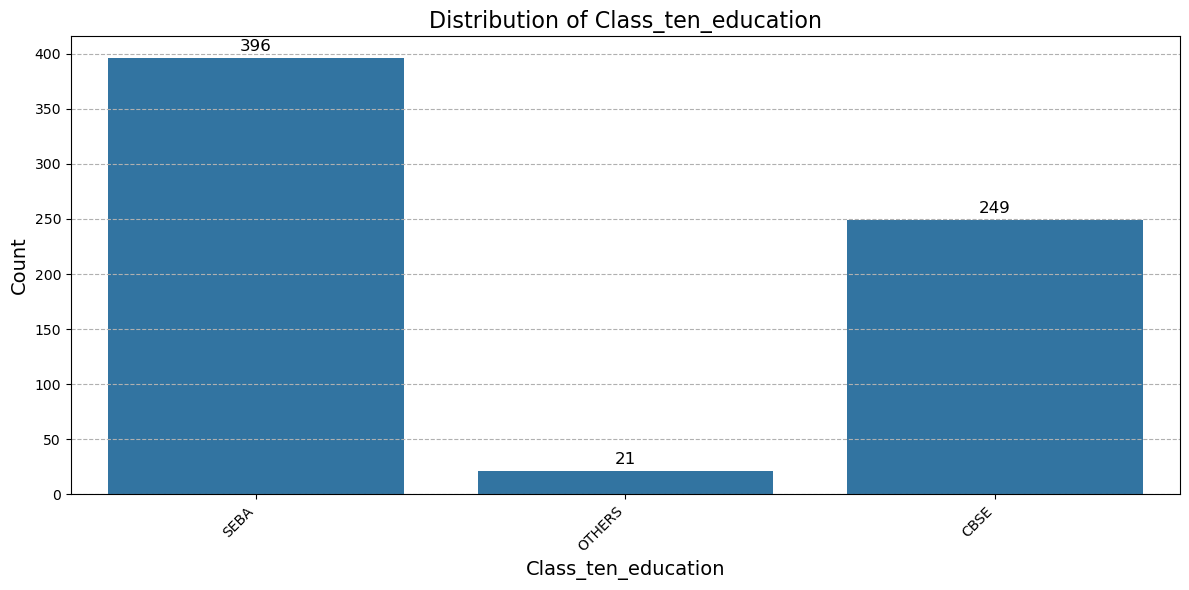

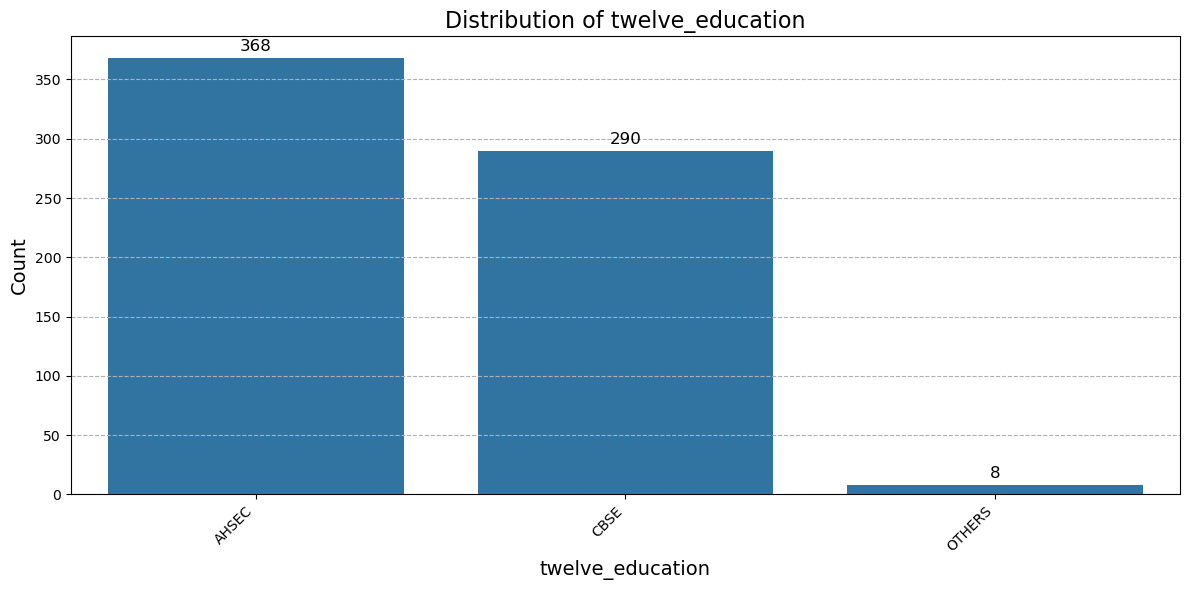

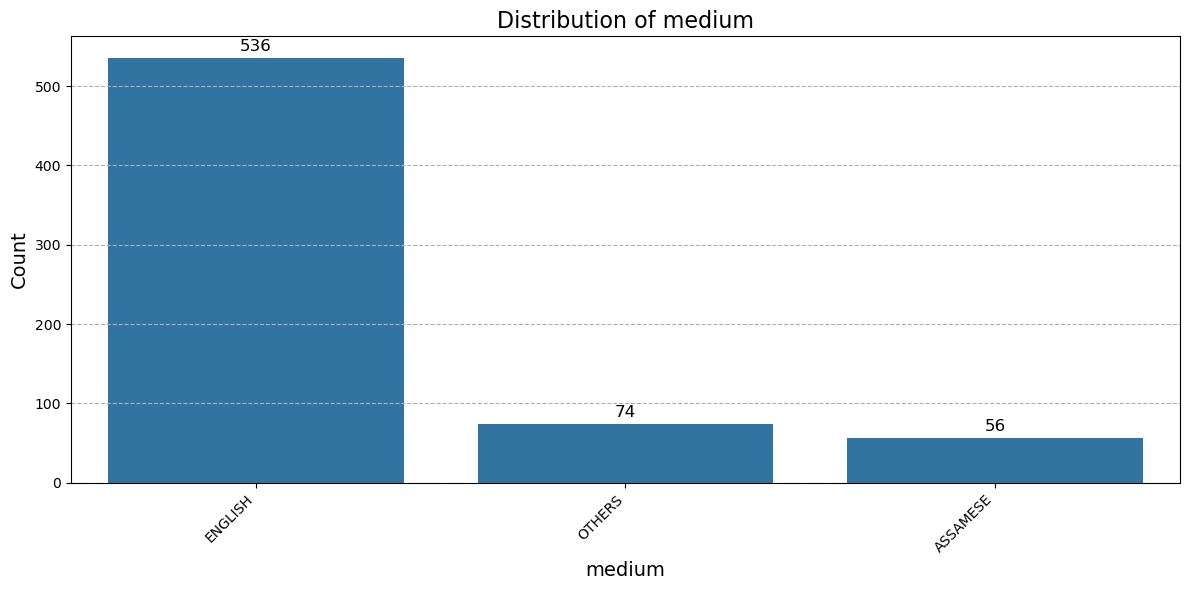

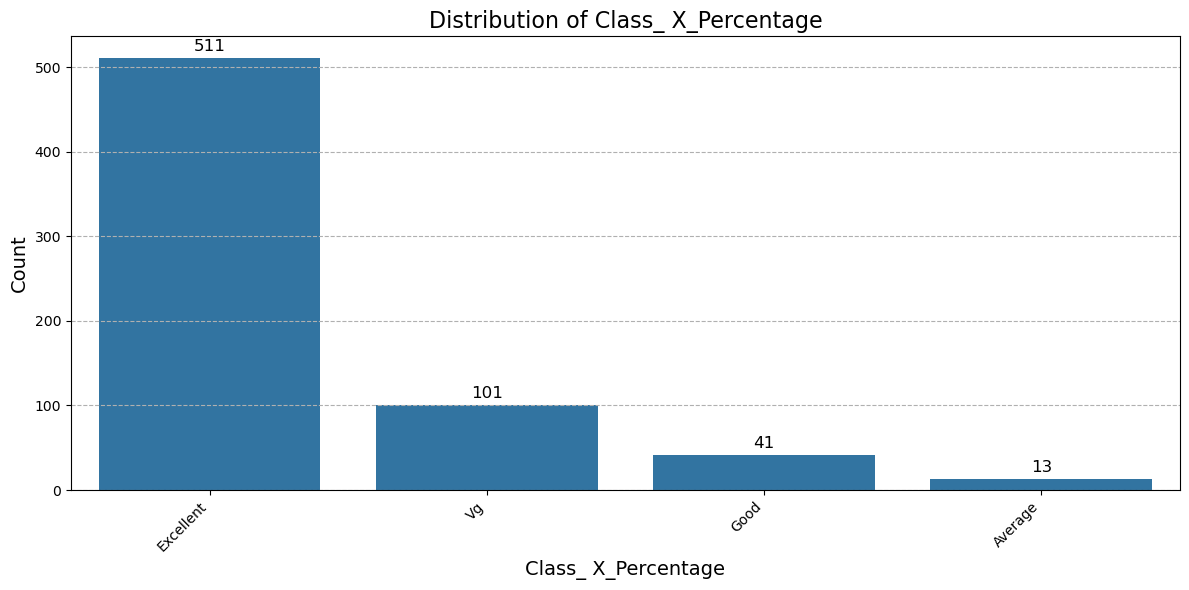

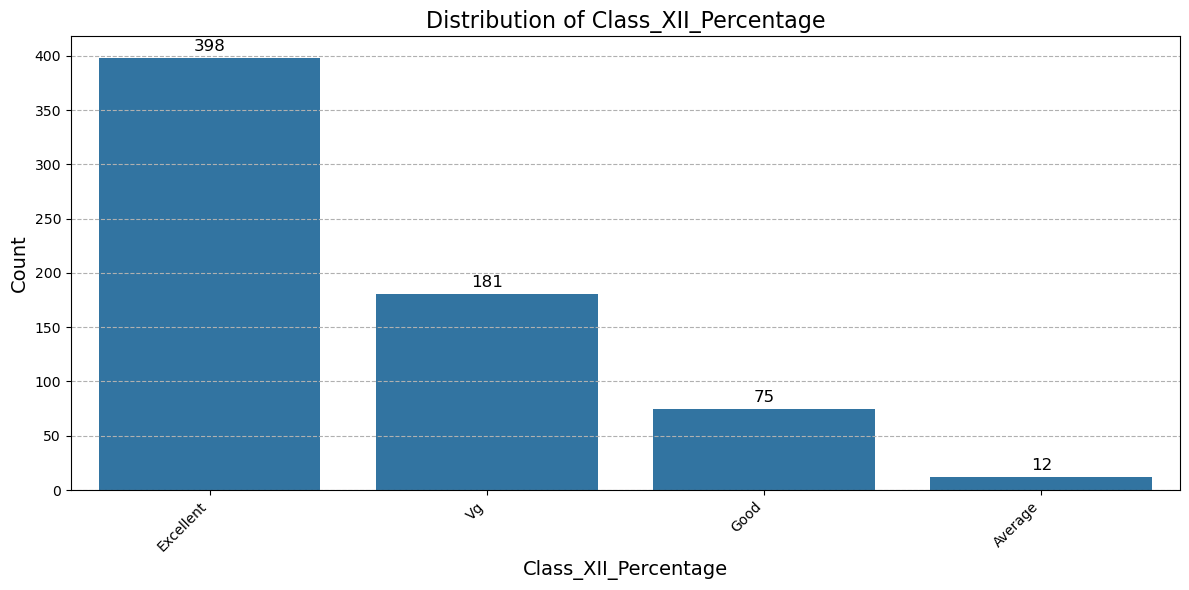

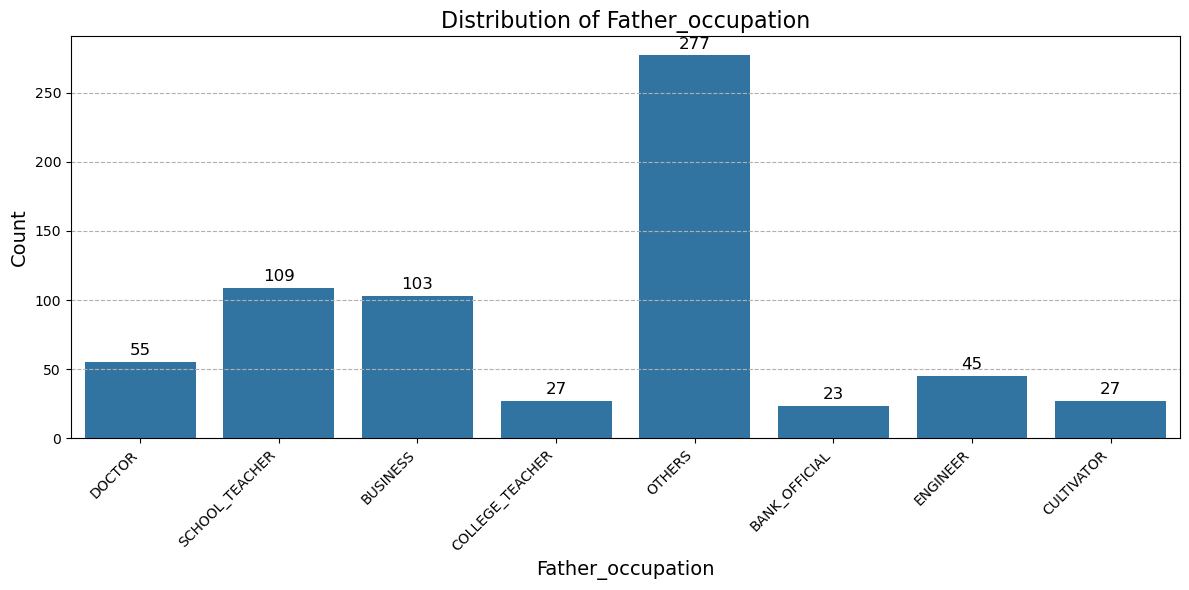

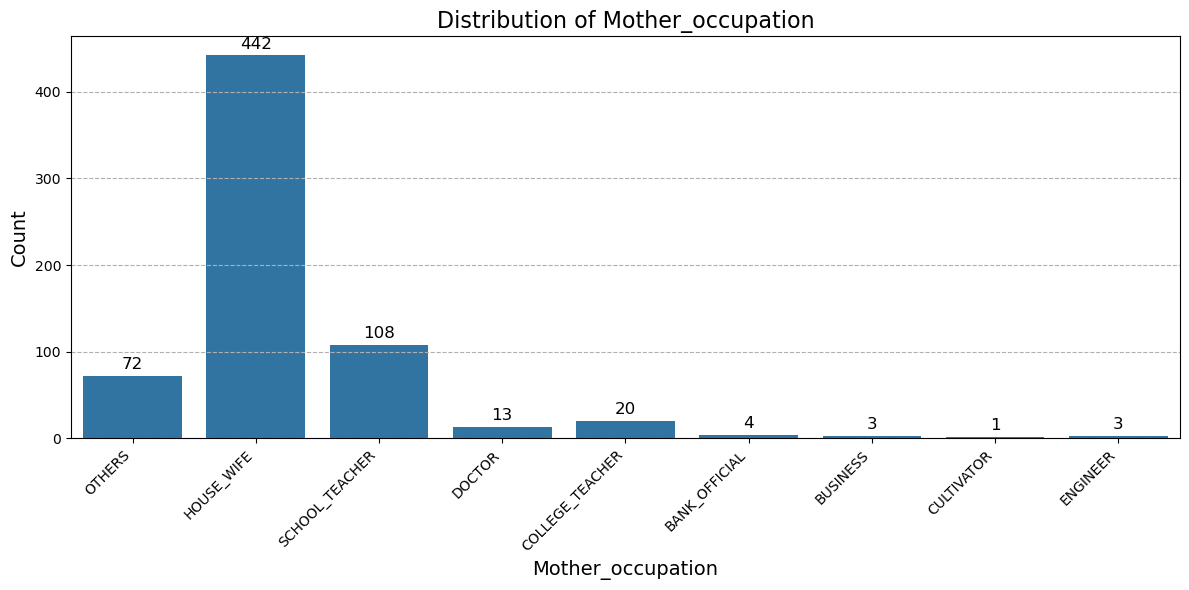

Model accuracy: 44.03%


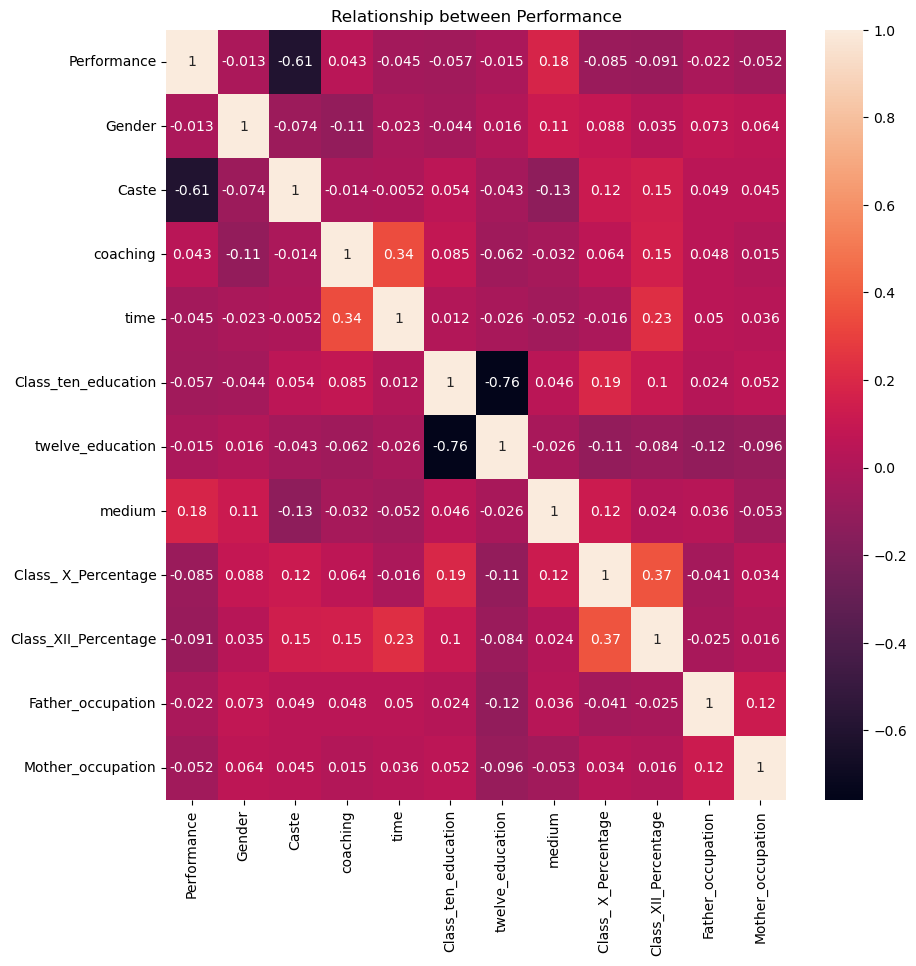

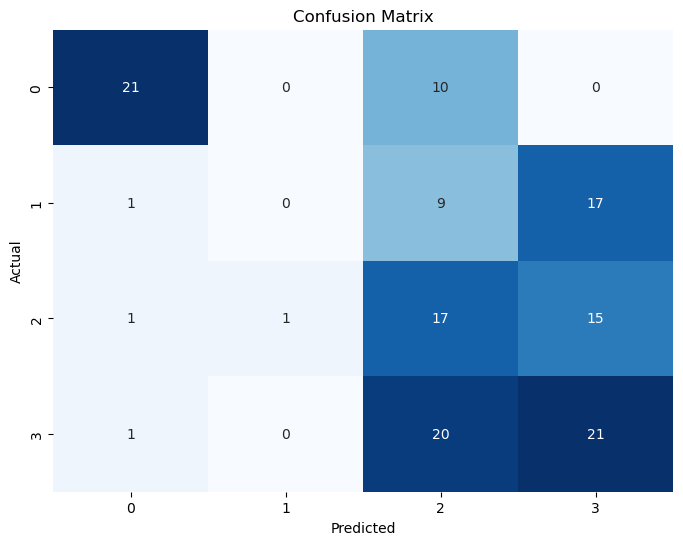

Classification Report before Grid Search:
              precision    recall  f1-score   support

           0       0.88      0.68      0.76        31
           1       0.00      0.00      0.00        27
           2       0.30      0.50      0.38        34
           3       0.40      0.50      0.44        42

    accuracy                           0.44       134
   macro avg       0.39      0.42      0.40       134
weighted avg       0.40      0.44      0.41       134

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
filepath='/Users/josedejesuspena/Documents/MLOps_Team_33/MLOps_Team_33/dataset/CEE_DATA.arff'
run_pipeline(filepath)